# Implementing doND using the dataset

This example notebook contains simple cases in which the `doNd` utilities of QCoDeS can be implemented. The `doNd` functions are generic wrappers of QCoDeS measurements in zero, one and two dimensions. In what follows, we shall provide the most basic functionalities and leave more detailed practices to the user. In particular, we shall not concern about single point measurements.

In [1]:
from functools import partial
import os

import numpy as np

from qcodes.utils.dataset.doNd import do1d, do2d, plot_data
from qcodes.dataset.sqlite.database import initialise_or_create_database_at
from qcodes.dataset.experiment_container import load_or_create_experiment
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_dataset

In [2]:
tutorial_db_path = os.path.join(os.getcwd(), 'tutorial_doND.db')
initialise_or_create_database_at(tutorial_db_path)
load_or_create_experiment("doNd-tutorial", sample_name="no sample")

doNd-tutorial#no sample#1@C:\Users\a-alhard\repos\Qcodes\docs\examples\DataSet\tutorial_doND.db
-----------------------------------------------------------------------------------------------
1-results-1-dac_ch1,dmm_v1,dmm_v2-20
2-results-2-dac_ch1,dmm_v1,dmm_v2-20
3-results-3-dac_ch1,dmm_v1,dmm_v2-20
4-results-4-dac_ch1,dmm_v1,dmm_v2-20
5-results-5-dac_ch1,dmm_v1,dmm_v2-20
6-results-6-dac_ch1,dmm_v1,dmm_v2-20
7-results-7-dac_ch1,dmm_v1,dmm_v2-20
8-results-8-dac_ch1,dmm_v1,dmm_v2-100
9-results-9-dac_ch1,dmm_v1,dmm_v2-100
10-results-10-dac_ch1,dmm_v1,dmm_v2-100
11-results-11-dac_ch1,dac_ch2,dmm_v1,dmm_v2-20000
12-results-12-dac_ch1,dac_ch2,dmm_v1,dmm_v2-20000
13-results-13-dac_ch1,dmm_v1,dmm_v2-60
14-results-14-dac_ch1,dac_ch2,dmm_v1,dmm_v2-20000

First we borrow the dummy instruments from the contextmanager notebook to have something to measure.

In [3]:
# preparatory mocking of physical setup
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrument('dmm', gates=['v1', 'v2'])

In [4]:
# and we'll make a 2D gaussian to sample from/measure
def gauss_model(x0: float, y0: float, sigma: float, noise: float=0.0005):
    """
    Returns a generator sampling a gaussian. The gaussian is
    normalised such that its maximal value is simply 1
    """
    while True:
        (x, y) = yield
        model = np.exp(-((x0-x)**2+(y0-y)**2)/2/sigma**2)*np.exp(2*sigma**2)
        noise = np.random.randn()*noise
        yield model + noise

In [5]:
# and finally wire up the dmm v1 to "measure" the gaussian

gauss = gauss_model(0.1, 0.2, 0.25)
next(gauss)

def measure_gauss(dac):
    val = gauss.send((dac.ch1.get(), dac.ch2.get()))
    next(gauss)
    return val

dmm.v1.get = partial(measure_gauss, dac)

Now let us use `do1d` function to make a simple one dimensional sweep. 

In [6]:
dataset = do1d(dac.ch1, 0, 1, 10, 0.01, dmm.v1, dmm.v2, do_plot = False)

Starting experimental run with id: 15. 


Starting experimental run with id: 16. 


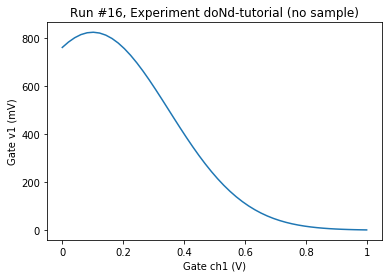

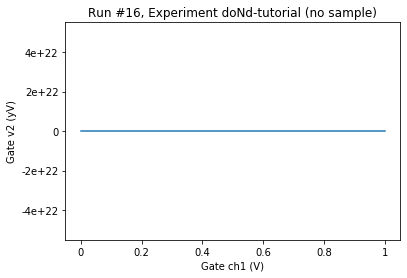

In [7]:
dataset = do1d(dac.ch1, 0, 1, 50, 0.01, dmm.v1, dmm.v2, do_plot = True)

Now, let us have a two dimensional sweep over gate voltages:

In [8]:
dataset = do2d(dac.ch1, -1, 1, 100, 0.01, 
                     dac.ch2, -1, 1, 100, 0.01, 
                     dmm.v1, dmm.v2, do_plot = False)

Starting experimental run with id: 17. 


Starting experimental run with id: 18. 


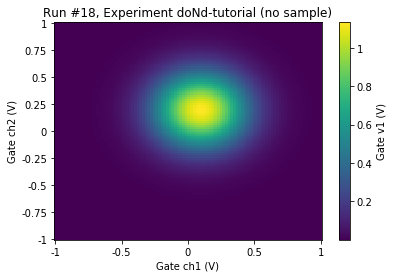

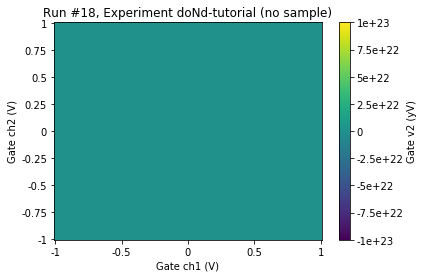

In [9]:
dataset = do2d(dac.ch1, -1, 1, 100, 0.01, 
                     dac.ch2, -1, 1, 100, 0.01, 
                     dmm.v1, dmm.v2, do_plot = True)

Noe that `do_plot = True` if the default value and we only added it for the sake of explicitness. The `doNd` utility, in fact, uses an internal public function called `plot_data` to handle data visualization, which by default saves the figures in both pdf and png formats, as well. Therefore, users, if needed, can only do their measurements with the option `do_plot = False` and then pass the relevant dataset to `plot_data` when visualization is necessary and choose to save figures in a desired format.

Internally, the `doNd` functions returns a tuple of which the first element is the dataset obtained in the measurement. Thus, if the `plot_data` shall be used explicitly after the measurement, one has to pass the first argument of the return value. 

In [10]:
dataset1d = do1d(dac.ch1, 0, 0.25, 30, 0.01, dmm.v1, dmm.v2, do_plot = False)

Starting experimental run with id: 19. 


In [11]:
dataset2d = do2d(dac.ch1, -0.6, 0.6, 100, 0.01, 
                     dac.ch2, -0.6, 0.6, 100, 0.01, 
                     dmm.v1, dmm.v2, do_plot = False)

Starting experimental run with id: 20. 


(results #19@C:\Users\a-alhard\repos\Qcodes\docs\examples\DataSet\tutorial_doND.db
 ---------------------------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [None, None])

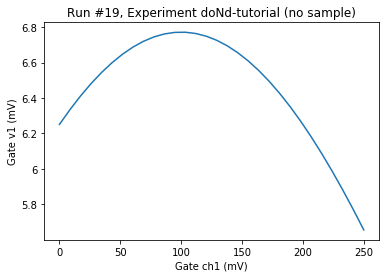

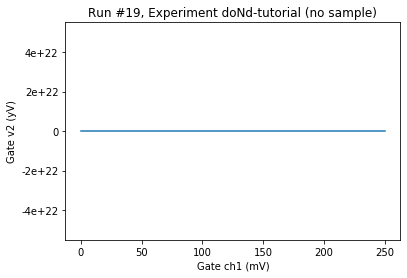

In [12]:
plot_data(dataset1d[0], save_pdf = False, save_png =True)

(results #20@C:\Users\a-alhard\repos\Qcodes\docs\examples\DataSet\tutorial_doND.db
 ---------------------------------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
  <matplotlib.colorbar.Colorbar at 0x29b9334dac8>])

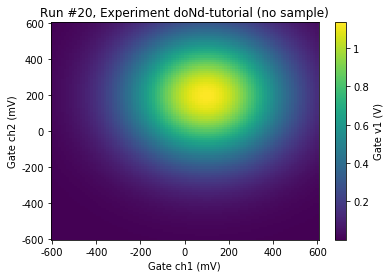

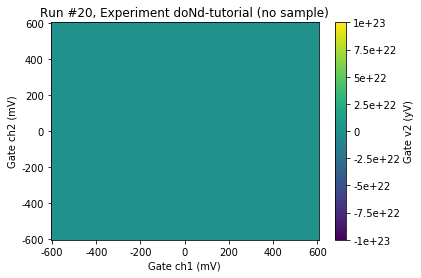

In [13]:
plot_data(dataset2d[0], save_pdf = True, save_png = False)